# Depth Space --> Density Space

In [13]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload

In [14]:
import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
reload(ff)
reload(ef)
reload(pf)

<module 'plot_funcs' from '/home.ufs/amf2288/argo-intern/plot_funcs.py'>

In [15]:
s_ds=xr.open_dataset("202206/202206_lon:(25,45)_lat:(-60,-50).nc")
s = ff.get_ds_interp(s_ds,0,2000,4)
s['SPICE'] = gsw.spiciness0(s.SA,s.CT).rename('SPICE')

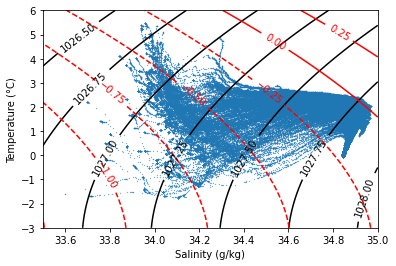

In [24]:
#something is wrong with density here, values look okay except that it should be 26.5-28, not 1026.5-1028
#now that I'm looking, this problem is also present in the function_test notebook, so need to troubleshoot there
#wait it's also in the CCS_poster notebook???? okay I really need to figure this out

ds_li=[s]
Taxis=[-3,6,50]
Saxis=[33.5,35,50]

pf.plot_TS(ds_li, Taxis, Saxis)

In [23]:
s.SIG0

<xarray.DataArray 'SIG0' (N_PROF: 335, PRES_INTERPOLATED: 1000)>
array([[27.24443264, 27.244423  , 27.24440588, ..., 27.83129576,
        27.83133727, 27.83145719],
       [27.31737275, 27.31732922, 27.31724487, ..., 27.83284714,
        27.83300474, 27.83309601],
       [27.29516936, 27.29507808, 27.29474617, ..., 27.82787652,
        27.82802536, 27.82822903],
       ...,
       [26.8579227 , 26.85792375, 26.85782355, ..., 27.82308438,
        27.82331563, 27.82350195],
       [26.87945178, 26.88002947, 26.88024853, ..., 27.80817163,
        27.80826524, 27.80835149],
       [27.23913462, 27.23913259, 27.23903377, ..., 27.82838973,
        27.82831031, 27.82832328]])
Coordinates:
  * N_PROF             (N_PROF) int64 1967 1968 1969 1970 ... 5848 5850 5913
    TIME               (N_PROF) datetime64[ns] 2015-07-11T03:25:10 ... 2021-0...
    LATITUDE           (N_PROF) float64 -52.29 -51.84 -51.16 ... -50.81 -51.94
    LONGITUDE          (N_PROF) float64 25.93 27.78 28.84 ... 31.38 30.96 32.08
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 2 4 6 ... 1992 1994 1996 1998
    N_PROF_NEW         (N_PROF) int64 0 1 2 3 4 5 6 ... 329 330 331 332 333 334
Attributes:
    casted:   1

In [20]:
import scipy.interpolate as interpolate

def func_var_int(ds, var, rho_grid, flag='group'):
    
    N_PROF_num = ds['N_PROF'].values
    
    rho = ds.SIG0
    rho_nonan = rho.where(~np.isnan(rho), drop=True)
    
    var_nonan = ds[var].where(~np.isnan(rho), drop=True)
    
    var_nonan2 = var_nonan.where(~np.isnan(var_nonan), drop=True)
    
    if flag == 'group': # incase density is identical b/w two points (this makes things very slow)
        var_nonan = var_nonan.groupby(rho_nonan).mean()
        rho_nonan = rho_nonan.groupby(rho_nonan).mean()
    
    if (len(rho_nonan)>2) & (len(var_nonan2)>2):
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', 'N_PROF'],
                        coords = {'rho_grid': rho_grid, 'N_PROF': [N_PROF_num]}).rename(var)

In [ ]:
s_rho